# PART 2 - Evaluation of COMPAS dataset

#### Group Members : 
                Marck-Edward KEMEH - marck-edward.kemeh@grenoble-inp.org
                Irman FAQRIZAL - irman.faqrizal@univ-grenoble-alpes.fr

In [1]:
# Increase my page width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import urllib
import os,sys
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tensorflow as tf
import scikitplot as skplt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pylab import rcParams
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import feature_extraction, preprocessing
from random import seed, shuffle
import math
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 10, 6
RANDOM_SEED = 42
df = pd.read_csv('compas-scores-two-years.csv')

<h2>2.1 Preprocessing </h2>
Before going further to building the classifiers, we will preprocess our data. First we select the needed colums and removing empty values.

In [2]:
df = df[df.columns[~df.isnull().any()]]
df = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', 'two_year_recid']]
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,Male,Greater than 45,Other,0,0,0,F,0,1,0,0
1,Male,25 - 45,African-American,0,0,0,F,1,1,1,1
2,Male,Less than 25,African-American,0,0,4,F,0,3,0,1
3,Male,Less than 25,African-American,0,1,1,F,0,6,0,0
4,Male,25 - 45,Other,0,0,2,F,0,1,0,0


Next we need to convert string data into values/ numbers to be able to use it to train, test and predict

In [3]:
df['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)
df.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


Next step is to divide our dataset. we divide the data into train and test set. we will use 0.2 percent of the training dataset as the test set. We also separate the features (X) and the ground truth (y).

In [4]:
X = df[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
y = df[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

<h2>2.2 Classifiers</h2>
<h3> NOTE - Re running the code might result in little variations of the values obtained from the classification</h3>

In this part we will present different type of classifiers. The first goal is to compare them with the compas classifier in terms of overall performance, in this case we will the basic metrics such as accuracy, precision, and recall. Then we will observe and compare the fairness to the existing COMPAS classifier. we will use the following for prediction of our data;
   
        1. Logistic Regression
        2. Support Vector Machines
        3. Decision Tress
        3. K-nearest Neighbors
        5. Neural Networks

<h4>1. Logistic Regresssion</h4>
Logistic regression isused for prediction.  Logistic regression is used to describe data and to explain the relationship between one dependent binary variables.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.97      0.93       823
       Recid       0.95      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9112959112959113


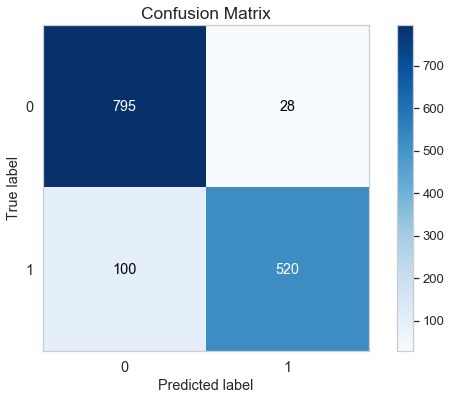

In [5]:
# Logistic Regression 
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train.values.ravel())
print (log_reg,'\n\n')

#prediction
y_pred = log_reg.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can observe from the classification report that logistic regression performs well . Precision and recall is at 0.91 which is a good measurement considering the best has to be 1 to indicate that all predictions were correctly made.
Details can be view in the confusion matrix were true positives (520) and true negatives (795) have a higher values as compared to False positives (28) and False negatives(100).


<h4>2. Support Vector Machine</h4>
Support vector machine algorithm is used to find hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points to get nearly accurate predictions.

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False) 


classification report 
               precision    recall  f1-score   support

    No Recid       0.89      0.96      0.92       823
       Recid       0.94      0.84      0.89       620

    accuracy                           0.91      1443
   macro avg       0.92      0.90      0.91      1443
weighted avg       0.91      0.91      0.91      1443

Overall Accuracy :  0.9106029106029107


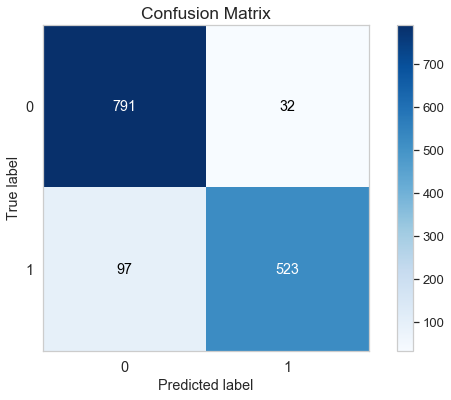

In [6]:
clfsvm = svm.SVC()
clfsvm.fit(X_train, y_train.values.ravel())
print (clfsvm,'\n\n')

#prediction
y_pred = clfsvm.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

we can see from the classification report that precision and recall stands at 0.91 which is a good indication of the classifier.
confusion matrix were true positives (523) and true negatives (795) have a higher values as compared to False positives (32) and False negatives(97).
comparing with Logistic regression, the predictions variations is very negligible.

<h4>3. Decision Tree Classifier </h4>
Decion tres work more like an if-else consition. It split the data and continuously split the data based on the features available .until it reaches the lowers point.

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.93      0.90       823
       Recid       0.90      0.82      0.86       620

    accuracy                           0.88      1443
   macro avg       0.89      0.88      0.88      1443
weighted avg       0.88      0.88      0.88      1443

Overall Accuracy :  0.8828828828828829


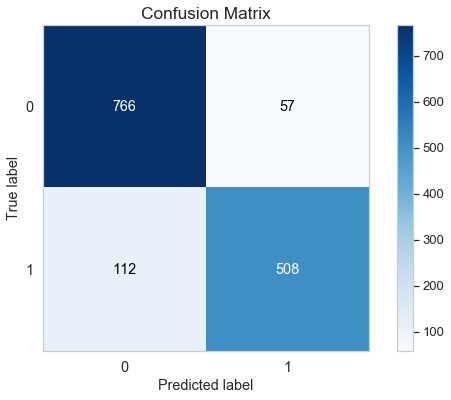

In [7]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
print (clf,'\n\n')

#prediction
y_pred = clf.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

For decision trees, we can see our performance matrix have reduced to 0.88 as compared to SVM and logistic regression. One problem of decision trees is that it can create over-complex trees that do not generalize the data well for accurate predictions and also small variations in the data might result in a different tree being generated. This also affects the prediction.

But from above we can see that the performance metric is quite ok. the predictions are also not far from the other classifiers we saw previously. we have true positives (509) and true negatives (763) have a higher values as compared to False positives (60) and False negatives(111).

<h4>4. K Nearest Neighbors </h4>

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform') 


classification report 
               precision    recall  f1-score   support

    No Recid       0.86      0.92      0.89       823
       Recid       0.88      0.80      0.84       620

    accuracy                           0.87      1443
   macro avg       0.87      0.86      0.86      1443
weighted avg       0.87      0.87      0.87      1443

Overall Accuracy :  0.8669438669438669


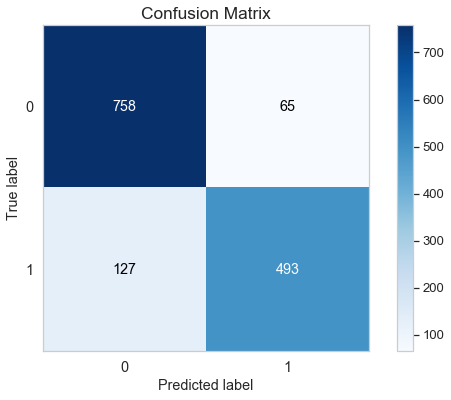

In [8]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train.values.ravel())
print (neigh,'\n\n')

#prediction
y_pred = neigh.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

From the performance metrics, K nearest neighbours also performs less as compared to Logistic Regression and SVM. 
using this has increase the number of misclassifications as compared to Decision trees even though the accuracy is almost performance metric is almost same (0.87).
we have true positives (493) and true negatives (758) have a higher values as compared to False positives (65) and False negatives(127).

<h4>5. Neural Network </h4>
In order to train the neural network we will have to split the data training again to get validation set. We then need to convert them into a tensor to be able to train and test with Pytorch.

In [9]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_SEED)

# conversion to tensor
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
X_validate = torch.from_numpy(X_validate.to_numpy()).float()
y_validate = torch.squeeze(torch.from_numpy(y_validate.to_numpy()).float())

print("Training\t :"+ str(X_train.shape) +", "+ str(y_train.shape))
print("Testing\t\t :"+ str(X_test.shape) +", "+ str(y_test.shape))
print("Validation\t :"+ str(X_validate.shape) +", "+ str(y_validate.shape))

Training	 :torch.Size([5193, 10]), torch.Size([5193])
Testing		 :torch.Size([1443, 10]), torch.Size([1443])
Validation	 :torch.Size([578, 10]), torch.Size([578])


#### First Model
Our first model will use simple architecture of neural network which has 3 convolutional layers. A batch size of 100, learning rate of 0.001

firstmodel(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.744, Acc: 0.402 	|| Validation : - Loss: 0.73, Acc: 0.438
epoch {50} 	==> Train : - Loss: 0.342, Acc: 0.891 	|| Validation : - Loss: 0.312, Acc: 0.9
epoch {100} 	==> Train : - Loss: 0.335, Acc: 0.891 	|| Validation : - Loss: 0.309, Acc: 0.901
epoch {150} 	==> Train : - Loss: 0.331, Acc: 0.891 	|| Validation : - Loss: 0.308, Acc: 0.901
epoch {200} 	==> Train : - Loss: 0.332, Acc: 0.891 	|| Validation : - Loss: 0.307, Acc: 0.901
epoch {250} 	==> Train : - Loss: 0.331, Acc: 0.891 	|| Validation : - Loss: 0.307, Acc: 0.901
epoch {300} 	==> Train : - Loss: 0.33, Acc: 0.891 	|| Validation : - Loss: 0.307, Acc: 0.901
epoch {350} 	==> Train : - Loss: 0.329, Acc: 0.891 	|| Validation : - Loss: 0.307, Acc: 0.9

 classification report 
               precision    recall  f1-sc

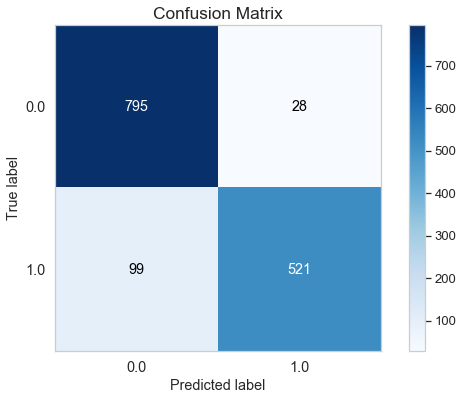

In [10]:
# Defining the model #1
class firstmodel(nn.Module):
  def __init__(self, n_features):
    super(firstmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net1 = firstmodel(X_train.shape[1])
print(net1)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net1.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net1(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net1(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net1(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print('\n classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)


The performance metrics for this model stands at 0.92 which is a little improvement as compared to the previous classifiers. we have true positives (520) and true negatives (801) have a higher values as compared to False positives (22) and False negatives(100)
### Second model
In this model we added more layers and neurons. We also try to use different activation function.

secondmodel(
  (fc1): Linear(in_features=10, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=1, bias=True)
)


epoch {0} 	==> Train : - Loss: 0.643, Acc: 0.652 	|| Validation : - Loss: 0.64, Acc: 0.663
epoch {50} 	==> Train : - Loss: 0.325, Acc: 0.891 	|| Validation : - Loss: 0.297, Acc: 0.9
epoch {100} 	==> Train : - Loss: 0.328, Acc: 0.891 	|| Validation : - Loss: 0.299, Acc: 0.9
epoch {150} 	==> Train : - Loss: 0.325, Acc: 0.891 	|| Validation : - Loss: 0.301, Acc: 0.898
epoch {200} 	==> Train : - Loss: 0.32, Acc: 0.891 	|| Validation : - Loss: 0.302, Acc: 0.898
epoch {250} 	==> Train : - Loss: 0.313, Acc: 0.891 	|| Validation : - Loss: 0.3, Acc: 0.901
epoch {300} 	==> Train : - Loss: 0.302, Acc: 0.891 	|| Validation : - Loss: 0.299, Acc: 0.901
epoch {350} 	==> Train : - Loss: 0.294, Acc: 0.891 	|| Validation : - Loss: 0.3, Acc: 0.896

 cla

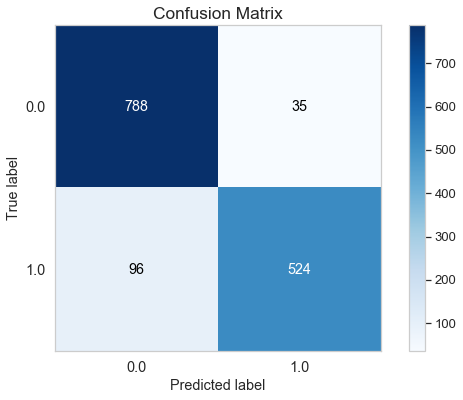

In [11]:
# Defining the model  #2
# Adding layers and neurons
class secondmodel(nn.Module):

  def __init__(self, n_features):
    super(secondmodel, self).__init__()
    self.fc1 = nn.Linear(n_features, 20)
    self.fc2 = nn.Linear(20, 20)
    self.fc3 = nn.Linear(20, 10)
    self.fc4 = nn.Linear(10, 1)

  def forward(self, x):
    x = torch.tanh(self.fc1(x))
    x = torch.tanh(self.fc2(x))
    x = torch.tanh(self.fc3(x))
    return torch.sigmoid(self.fc4(x))

net = secondmodel(X_train.shape[1])
print(net)

def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
print("\n")
max_epochs = 400
batch_size = 100
batch_number = math.ceil(len(X_train)/batch_size)
for epoch in range (max_epochs):
    for batch_idx in range (batch_number):
        # Set up batch
        batch_end = ((batch_idx+1) * batch_size -1)
        batch_start = batch_idx * batch_size
        if (batch_idx == (batch_number-1)):
            batch_end = (len(X_train) -1)
        batch_x = X_train[batch_start : batch_end]
        batch_y = y_train[batch_start : batch_end]
        
        # Fit the training data and validate
        train_pred = net(batch_x)
        train_pred = torch.squeeze(train_pred)
        train_loss = criterion(train_pred, batch_y)
        train_acc = calculate_accuracy(batch_y, train_pred)
        y_validate_pred = net(X_validate)
        y_validate_pred = torch.squeeze(y_validate_pred)
        validate_loss = criterion(y_validate_pred, y_validate)
        validation_acc = calculate_accuracy(y_validate, y_validate_pred)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    if epoch % 50 == 0:
        print( f'''epoch { {epoch} } \t==> Train : - Loss: {round_tensor(train_loss)}, Acc: {round_tensor(train_acc)} \t|| Validation : - Loss: {round_tensor(validate_loss)}, Acc: {round_tensor(validation_acc)}''')


# Test the model using test set
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print('\n classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

from the two models described, we can see the perform almost equally but model 2 outperforms the first model by a difference in accuarcy of 0.003. there is also slight variation in the classifications based ont the confusion matrixes.
we have true positives (527) and true negatives (793) have a higher values as compared to False positives (30) and False negatives(93)
From both model, we can conclude that the performance is almost equal as the other classifiers we described above.

Model 2 outperforms model 1 looking as the confusion matrix values.

Looking at the performance metrics of all our classifiers, they actually perform better compared to compass mode of prediction. We will recommend to use Logitic rgression, SVM or Neural networks to for the classification and prediction (based on the performances of our networks).

### Predictions based on best performing model (model 2) 

we want to define a new dataset to use for prediction and observe fairness. We will use criminals labelled with the various risk score/decile score but having a two_year_recid or for this analysis. we will analyse the predictions based using the confusion matrix.


shape of data is  (284, 10)


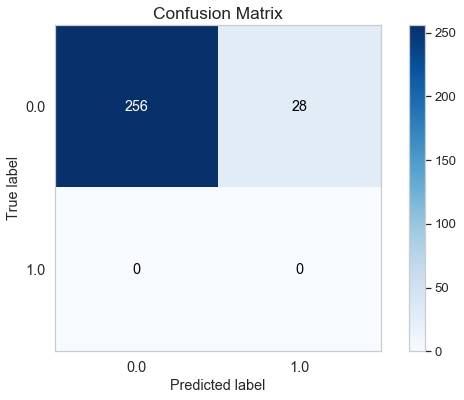

In [12]:
df2 = pd.read_csv('compas-scores-two-years.csv')

df2['sex'].replace({'Male': 1, 'Female': 2}, inplace = True)
df2['age_cat'].replace({'Greater than 45': 1, '25 - 45': 2, 'Less than 25': 3}, inplace = True)
df2['race'].replace({'Other': 1, 'African-American': 2, 'Caucasian': 3, 'Hispanic': 4, 'Native American': 5, 'Asian': 6}, inplace = True)
df2['c_charge_degree'].replace({'F': 1, 'M': 2}, inplace = True)

#no two_year _recid with high label
df2 = df2.loc[(df2['two_year_recid']==0) & (df2['score_text']=='High') & (df2['race']==2)]
# print ('shape of filtered data is ', df2.shape)

df2 = df2[df.columns[~df.isnull().any()]]
dfY = df2[['two_year_recid', ]]  #ground truth
dfX = df2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event', ]]

print ('shape of data is ', dfX.shape)

#prediction
y_test = torch.from_numpy(dfY.to_numpy()).float()
X_test = torch.from_numpy(dfX.to_numpy()).float()
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
skplt.metrics.plot_confusion_matrix(y_test, y_pred)

## 2.3 Feature Sets
we want to remove some features to determine what affets the classification or prediction of the criminals. this will inform us the feature set that are really important to use.
for this section, we use use the logistic regression classifier we define above to determine the feature sets.

In [13]:
dfnew = df
dfnew.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,priors_count,c_charge_degree,is_violent_recid,v_decile_score,event,two_year_recid
0,1,1,1,0,0,0,1,0,1,0,0
1,1,2,2,0,0,0,1,1,1,1,1
2,1,3,2,0,0,4,1,0,3,0,1
3,1,3,2,0,1,1,1,0,6,0,0
4,1,2,1,0,0,2,1,0,1,0,0


<b>1.</b> Firstly, we remove 'v_decile_score' and 'is_violent_recid' from the features to analyse the performance

In [14]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.88      0.96      0.92       823
       Recid       0.94      0.82      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see from the classification report that removing 'v_decile_score' and 'is_violent_recid' from the feature set does not really affect the peformance of the classifier. Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91

<b>2.</b> In the next part we remove 'juv_fel_count' and 'c_charge_degree' in addition to the previously removed features to analyse the performance.

In [15]:
X_new = dfnew[['sex','age_cat', 'race', 'juv_misd_count', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.88       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9015939015939016


we can see from the classification report that removing 'juv_fel_count' and 'c_charge_degree' also does not have much effect on the peformance of the classifier. 
Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. we still need to remove more features to determine the needed features.

<b>3.</b> in the next part we remove 'sex','age_cat'and 'juv_misd_count' in addition to previously removed features

In [16]:
X_new = dfnew[[ 'race', 'priors_count', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.97      0.92       823
       Recid       0.95      0.81      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.90      0.90      0.90      1443

Overall Accuracy :  0.8995148995148995


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.89 as compared to the original set which gave us 0.91. Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

<b>4.</b> in the next part we remove 'priors_count' 

In [17]:
X_new = dfnew[['race', 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


Again Performance metric (accuarcy, precision and recall) is 0.90 and overall accuracy is also 0.90 as compared to the original set which gave us 0.91. 
Performance is actually still good in this regard. We still need to remove more features to determine the needed features.

<b>4.</b> in the next part we remove 'event' 

In [18]:
X_new = dfnew[[ 'race']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.56      0.93      0.70       823
       Recid       0.33      0.04      0.08       620

    accuracy                           0.55      1443
   macro avg       0.45      0.49      0.39      1443
weighted avg       0.46      0.55      0.43      1443

Overall Accuracy :  0.5509355509355509


we can see that removing event and only considering race, overall accuracy now stands at 0.55 which is pretty bad. This tells us that the 'event' feature is necessary to give us an accurate prediction

<b>5.</b> in the next part we remove 'race' 

In [19]:
#removing v_decile_score, is violent recid, c_charge_degree, juv_misd_count, juv_fel_count, age_cat, prior_count, sex
X_new = dfnew[[ 'event']]
y_new = dfnew[['two_year_recid']] #ground truth
classes = ['No Recid', 'Recid']

# Arrange the data : Training, Testing
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=RANDOM_SEED)

# Logistic Regression 
log_reg_new = LogisticRegression()
log_reg_new.fit(X_train, y_train.values.ravel())
# print (log_reg_new,'\n\n')

#prediction
y_pred = log_reg_new.predict(X_test)
# skplt.metrics.plot_confusion_matrix(y_test, y_pred)
print('classification report \n', classification_report(y_test, y_pred, target_names=classes))
print("Overall Accuracy : " , str(accuracy_score(y_test, y_pred)))

classification report 
               precision    recall  f1-score   support

    No Recid       0.87      0.98      0.92       823
       Recid       0.96      0.80      0.87       620

    accuracy                           0.90      1443
   macro avg       0.91      0.89      0.90      1443
weighted avg       0.91      0.90      0.90      1443

Overall Accuracy :  0.9002079002079002


we can see that using the 'event' set alone gives us a good accuracy of 0.90. we can now conclude that event is one of the feature sets necessary for correct prediction.
using event alone gives us the same accuracy as using 'event' and 'race' feature

### Features to Use
From our analysis, we recommend using the 'event' in addition to any other feature set for the classification or prediction to be almost accurate.

## 2.4 Fairness
We will investigate the fairness of each classifier.
### Independence
According to the book. To satisfy independence the acceptance rate of a group should have at least ......

In here we will observe the independence of sensitive feature 'race' in particular 'African-American' compared to all other races. Therefore first we will have to filter the dataframe.

In [20]:
dffair1 = df.loc[(df['race']==2)]
Xfair1 = dffair1[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
yfair1 = dffair1[['two_year_recid']]

dffair2 = df.loc[(df['race']!=2)]
Xfair2 = dffair2[['sex','age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree', 
         'is_violent_recid', 'v_decile_score', 'event']]
yfair2 = dffair2[['two_year_recid']]

#### Logistic Regression

In [21]:
y_pred = log_reg.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
print("African-American acceptance rate\t = " + str(Pfair1_true))

y_pred = log_reg.predict(Xfair2)
Pfair2_true = np.sum(y_pred) / len(Xfair2)
print("Non African-American acceptance rate\t = " + str(Pfair2_true))

independence1 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence1 = Pfair2_true/Pfair1_true
    
print("Indepence\t\t\t\t = " + str(independence1))

African-American acceptance rate	 = 0.476461038961039
Non African-American acceptance rate	 = 0.34252416145537234
Indepence				 = 0.7188922775349552


#### Support Vector Machine

In [22]:
y_pred = clfsvm.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
print("African-American acceptance rate\t = " + str(Pfair1_true))

y_pred = clfsvm.predict(Xfair2)
Pfair2_true = np.sum(y_pred) / len(Xfair2)
print("Non African-American acceptance rate\t = " + str(Pfair2_true))

independence2 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence2 = Pfair2_true/Pfair1_true
    
print("Indepence\t\t\t\t = " + str(independence2))

African-American acceptance rate	 = 0.4875541125541126
Non African-American acceptance rate	 = 0.3479249573621376
Indepence				 = 0.7136130091068038


#### Decision Trees

In [23]:
y_pred = clf.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
print("African-American acceptance rate\t = " + str(Pfair1_true))

y_pred = clf.predict(Xfair2)
Pfair2_true = np.sum(y_pred) / len(Xfair2)
print("Non African-American acceptance rate\t = " + str(Pfair2_true))

independence3 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence3 = Pfair2_true/Pfair1_true
    
print("Indepence\t\t\t\t = " + str(independence3))

African-American acceptance rate	 = 0.48674242424242425
Non African-American acceptance rate	 = 0.3581580443433769
Indepence				 = 0.7358266436315292


#### K Nearest Neighbors

In [24]:
y_pred = neigh.predict(Xfair1)
Pfair1_true = np.sum(y_pred) / len(Xfair1)
print("African-American acceptance rate\t = " + str(Pfair1_true))

y_pred = neigh.predict(Xfair2)
Pfair2_true = np.sum(y_pred) / len(Xfair2)
print("Non African-American acceptance rate\t = " + str(Pfair2_true))

independence4 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence4 = Pfair2_true/Pfair1_true
    
print("Indepence\t\t\t\t = " + str(independence4))

African-American acceptance rate	 = 0.4880952380952381
Non African-American acceptance rate	 = 0.358726549175668
Indepence				 = 0.7349519544086857


#### Neural Network

In [25]:
Xfair1net = torch.from_numpy(Xfair1.to_numpy()).float()
Xfair2net = torch.from_numpy(Xfair2.to_numpy()).float()
y_pred = net(Xfair1net)
y_pred = y_pred.detach().numpy()
Pfair1_true = np.sum(y_pred) / len(Xfair1)
print("African-American acceptance rate\t = " + str(Pfair1_true))

y_pred = net(Xfair2net)
y_pred = y_pred.detach().numpy()
Pfair2_true = np.sum(y_pred) / len(Xfair2)
print("Non African-American acceptance rate\t = " + str(Pfair2_true))

independence5 = Pfair1_true/Pfair2_true
if Pfair1_true/Pfair2_true > 1:
    independence5 = Pfair2_true/Pfair1_true
    
print("Indepence\t\t\t\t = " + str(independence5))

African-American acceptance rate	 = 0.502481865160393
Non African-American acceptance rate	 = 0.37075925374857877
Indepence				 = 0.7378559893504453


0.7188922775349552


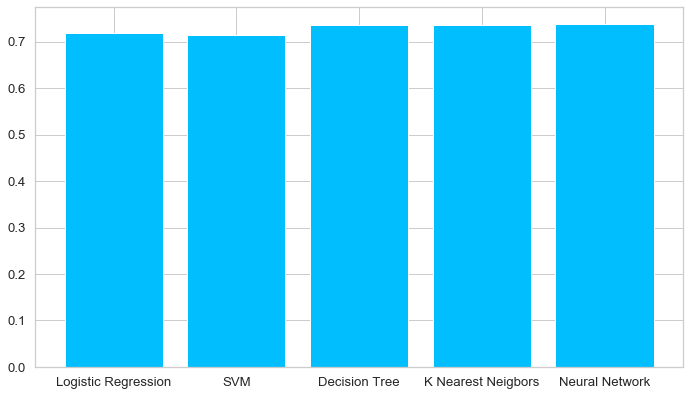

In [26]:
bottom = ["Logistic Regression", "SVM", "Decision Tree", "K Nearest Neigbors", "Neural Network"]
left = [independence1, independence2, independence3, independence4, independence5]
print(independence1)
fig = plt.figure()
fig.set_size_inches(9, 5)
ax = fig.add_axes([0,0,1,1])
ax.bar(bottom,left)
plt.show()

As we can see from the result above there is not much difference between classifiers. We will consider the best one and combine the results on performance analysis, and the feature sets.